ДЗ должна быть выполнена строго на torch
1 - использовать dataloader. 
2 - в цикл обучения добавить сохранения лучшей модели / шедулер для скорости обучения. 
3 - вывести графики обучения. Выводить информацию по обучению в процессе. 

Решить задачу предсказания возраста. Свести к задаче классификации. 
0- 9 10 -19 - 20 -29 30 -39 40 49 50 59 ...
 
В качестве фьючеэкстрактора используйте любую вариацию vit. ** - 

Использовался датасет UTKFace

In [1]:
import os
import cv2
import concurrent.futures
from datetime import datetime
import mediapipe as mp
import numpy as np

# Настройки
INPUT_DIR = "UTKFace/"
OUTPUT_DIR = "out2"
MIN_FACE_SIZE = 20  # пикселей
TARGET_SIZE = (224, 224) 
MIN_AGE = 1
MAX_AGE = 100
JPEG_QUALITY = 95
NUM_THREADS = os.cpu_count() or 4

# Статистика
processed_count = 0
error_count = 0

def extract_age(filename):
    try:
        # Ожидаемый формат: 27_1_2_20170116165450739.jpg.chip.jpg
        # Первое число до подчеркивания - возраст
        age_str = filename.split('_')[0]
        age = int(age_str)
        return age if (MIN_AGE <= age <= MAX_AGE) else None
    except Exception as e:
        print(f"Ошибка при извлечении возраста из {filename}: {str(e)}")
        return None

def process_image(file_path, filename, age):
    try:
        # Чтение изображения
        img = cv2.imread(file_path)
        if img is None:
            print(f"Не удалось прочитать изображение: {file_path}")
            return None

        # Конвертация в RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Детекция лиц
        with mp.solutions.face_detection.FaceDetection(
            min_detection_confidence=0.5,
            model_selection=1
        ) as face_detection:
            
            results = face_detection.process(img_rgb)
            
            if not results.detections:
                print(f"Лица не обнаружены: {file_path}")
                return None

            # Берем первое обнаруженное лицо
            detection = results.detections[0]
            bboxC = detection.location_data.relative_bounding_box
            ih, iw = img.shape[:2]
            
            x = int(bboxC.xmin * iw)
            y = int(bboxC.ymin * ih)
            w = int(bboxC.width * iw)
            h = int(bboxC.height * ih)

            if w < MIN_FACE_SIZE or h < MIN_FACE_SIZE:
                print(f"Слишком маленькое лицо: {file_path}")
                return None

            # Вырезаем лицо
            face_img = img[max(0,y):min(ih,y+h), max(0,x):min(iw,x+w)]
            h_face, w_face = face_img.shape[:2]
            
            # Ресайз с сохранением пропорций
            scale = min(TARGET_SIZE[0]/w_face, TARGET_SIZE[1]/h_face)
            new_w = int(w_face * scale)
            new_h = int(h_face * scale)
            resized = cv2.resize(face_img, (new_w, new_h))
            
            # Добавляем паддинг до нужного размера
            pad_w = (TARGET_SIZE[0] - new_w) // 2
            pad_h = (TARGET_SIZE[1] - new_h) // 2
            
            padded = cv2.copyMakeBorder(
                resized,
                top=pad_h,
                bottom=pad_h + (1 if (TARGET_SIZE[1] - new_h) % 2 else 0),
                left=pad_w,
                right=pad_w + (1 if (TARGET_SIZE[0] - new_w) % 2 else 0),
                borderType=cv2.BORDER_CONSTANT,
                value=[0,0,0]
            )
            
            return padded

    except Exception as e:
        print(f"Ошибка при обработке изображения {file_path}: {str(e)}")
        return None

def process_file(file_path):
    global processed_count, error_count
    
    try:
        filename = os.path.basename(file_path)
        age = extract_age(filename)
        if age is None:
            error_count += 1
            return None

        processed_img = process_image(file_path, filename, age)
        if processed_img is None:
            error_count += 1
            return None

        # Создаем папку для возраста, если ее нет
        age_dir = os.path.join(OUTPUT_DIR, str(age))
        os.makedirs(age_dir, exist_ok=True)
        
        output_path = os.path.join(age_dir, filename)
        cv2.imwrite(
            output_path,
            processed_img,
            [int(cv2.IMWRITE_JPEG_QUALITY), JPEG_QUALITY]
        )
        
        processed_count += 1
        if processed_count % 100 == 0:
            print(f"Обработано: {processed_count} файлов")
        return output_path

    except Exception as e:
        print(f"Ошибка при обработке файла {file_path}: {str(e)}")
        error_count += 1
        return None

def main():
    global processed_count, error_count
    
    # Подготовка выходной директории
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Сбор файлов
    file_paths = []
    for root, _, files in os.walk(INPUT_DIR):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_paths.append(os.path.join(root, file))

    print(f"Найдено {len(file_paths)} файлов для обработки")

    # Многопоточная обработка
    with concurrent.futures.ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
        futures = {executor.submit(process_file, fp): fp for fp in file_paths}
        
        for future in concurrent.futures.as_completed(futures):
            future.result()  # Просто ждем завершения

    # Вывод статистики
    print(f"\nОбработка завершена!")
    print(f"Успешно обработано: {processed_count}")
    print(f"Ошибок обработки: {error_count}")
    print(f"Всего файлов: {len(file_paths)}")
    print(f"Процент успеха: {processed_count/len(file_paths)*100:.2f}%")

if __name__ == "__main__":
    main()

Найдено 23708 файлов для обработки
Лица не обнаружены: UTKFace/100_1_0_20170119212053665.jpg.chip.jpg
Лица не обнаружены: UTKFace/100_1_0_20170112213303693.jpg.chip.jpg
Лица не обнаружены: UTKFace/100_1_0_20170110183726390.jpg.chip.jpg
Лица не обнаружены: UTKFace/100_1_0_20170112215032192.jpg.chip.jpg
Лица не обнаружены: UTKFace/100_0_0_20170112213500903.jpg.chip.jpg
Лица не обнаружены: UTKFace/100_1_0_20170112213001988.jpg.chip.jpg
Лица не обнаружены: UTKFace/100_1_0_20170117195420803.jpg.chip.jpg
Лица не обнаружены: UTKFace/100_0_0_20170112215240346.jpg.chip.jpg
Лица не обнаружены: UTKFace/100_1_2_20170112213615815.jpg.chip.jpg
Лица не обнаружены: UTKFace/100_1_2_20170105174847679.jpg.chip.jpg
Лица не обнаружены: UTKFace/100_1_2_20170112222336458.jpg.chip.jpg
Лица не обнаружены: UTKFace/10_0_0_20170103200329407.jpg.chip.jpg
Лица не обнаружены: UTKFace/10_0_0_20170104013211746.jpg.chip.jpg
Лица не обнаружены: UTKFace/10_0_0_20170110220111082.jpg.chip.jpg
Лица не обнаружены: UTKFace/10

Используем модель с huggyface vit-base-patch16-224-in21k. Попробуем решить как задачу классификации, так и регрессии.

d:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Python\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(



Epoch 1/50


  Train Loss: 2.5828, Accuracy: 0.2952
  Val   Loss: 2.2862, Accuracy: 0.3350
  >>> Best model saved with val_acc = 0.3350

Epoch 2/50


  Train Loss: 2.1426, Accuracy: 0.3315
  Val   Loss: 2.0320, Accuracy: 0.3393
  >>> Best model saved with val_acc = 0.3393

Epoch 3/50


  Train Loss: 1.9603, Accuracy: 0.3415
  Val   Loss: 1.9084, Accuracy: 0.3556
  >>> Best model saved with val_acc = 0.3556

Epoch 4/50


  Train Loss: 1.8563, Accuracy: 0.3632
  Val   Loss: 1.8317, Accuracy: 0.3677
  >>> Best model saved with val_acc = 0.3677

Epoch 5/50


  Train Loss: 1.7864, Accuracy: 0.3770
  Val   Loss: 1.7783, Accuracy: 0.3812
  >>> Best model saved with val_acc = 0.3812

Epoch 6/50


  Train Loss: 1.7349, Accuracy: 0.3918
  Val   Loss: 1.7387, Accuracy: 0.3841
  >>> Best model saved with val_acc = 0.3841

Epoch 7/50


  Train Loss: 1.6953, Accuracy: 0.4014
  Val   Loss: 1.7083, Accuracy: 0.3876
  >>> Best model saved with val_acc = 0.3876

Epoch 8/50


  Train Loss: 1.6634, Accuracy: 0.4117
  Val   Loss: 1.6843, Accuracy: 0.3947
  >>> Best model saved with val_acc = 0.3947

Epoch 9/50


  Train Loss: 1.6367, Accuracy: 0.4174
  Val   Loss: 1.6646, Accuracy: 0.4026
  >>> Best model saved with val_acc = 0.4026

Epoch 10/50


  Train Loss: 1.6142, Accuracy: 0.4215
  Val   Loss: 1.6473, Accuracy: 0.3990

Epoch 11/50


  Train Loss: 1.5948, Accuracy: 0.4258
  Val   Loss: 1.6332, Accuracy: 0.4047
  >>> Best model saved with val_acc = 0.4047

Epoch 12/50


  Train Loss: 1.5777, Accuracy: 0.4268
  Val   Loss: 1.6208, Accuracy: 0.4033

Epoch 13/50


  Train Loss: 1.5625, Accuracy: 0.4306
  Val   Loss: 1.6099, Accuracy: 0.4040

Epoch 14/50


  Train Loss: 1.5488, Accuracy: 0.4343
  Val   Loss: 1.6001, Accuracy: 0.4033

Epoch 15/50


  Train Loss: 1.5365, Accuracy: 0.4384
  Val   Loss: 1.5914, Accuracy: 0.4011

Epoch 16/50


  Train Loss: 1.5251, Accuracy: 0.4414
  Val   Loss: 1.5841, Accuracy: 0.4047

Epoch 17/50


  Train Loss: 1.5148, Accuracy: 0.4435
  Val   Loss: 1.5771, Accuracy: 0.4040

Epoch 18/50


  Train Loss: 1.5050, Accuracy: 0.4476
  Val   Loss: 1.5709, Accuracy: 0.4047

Epoch 19/50


  Train Loss: 1.4961, Accuracy: 0.4519
  Val   Loss: 1.5643, Accuracy: 0.3990

Epoch 20/50


  Train Loss: 1.4878, Accuracy: 0.4555
  Val   Loss: 1.5593, Accuracy: 0.4061
  >>> Best model saved with val_acc = 0.4061

Epoch 21/50


  Train Loss: 1.4798, Accuracy: 0.4549
  Val   Loss: 1.5541, Accuracy: 0.4047

Epoch 22/50


  Train Loss: 1.4724, Accuracy: 0.4604
  Val   Loss: 1.5496, Accuracy: 0.4040

Epoch 23/50


  Train Loss: 1.4657, Accuracy: 0.4606
  Val   Loss: 1.5453, Accuracy: 0.4061

Epoch 24/50


  Train Loss: 1.4586, Accuracy: 0.4629
  Val   Loss: 1.5411, Accuracy: 0.4111
  >>> Best model saved with val_acc = 0.4111

Epoch 25/50


  Train Loss: 1.4526, Accuracy: 0.4647
  Val   Loss: 1.5378, Accuracy: 0.4083

Epoch 26/50


  Train Loss: 1.4466, Accuracy: 0.4681
  Val   Loss: 1.5343, Accuracy: 0.4061

Epoch 27/50


  Train Loss: 1.4408, Accuracy: 0.4695
  Val   Loss: 1.5307, Accuracy: 0.4090

Epoch 28/50


  Train Loss: 1.4355, Accuracy: 0.4715
  Val   Loss: 1.5277, Accuracy: 0.4054

Epoch 29/50


  Train Loss: 1.4301, Accuracy: 0.4763
  Val   Loss: 1.5253, Accuracy: 0.4083

Epoch 30/50


  Train Loss: 1.4250, Accuracy: 0.4780
  Val   Loss: 1.5224, Accuracy: 0.4075

Epoch 31/50


  Train Loss: 1.4201, Accuracy: 0.4777
  Val   Loss: 1.5202, Accuracy: 0.4118
  >>> Best model saved with val_acc = 0.4118

Epoch 32/50


  Train Loss: 1.4152, Accuracy: 0.4802
  Val   Loss: 1.5172, Accuracy: 0.4111

Epoch 33/50


  Train Loss: 1.4108, Accuracy: 0.4855
  Val   Loss: 1.5153, Accuracy: 0.4083

Epoch 34/50


  Train Loss: 1.4066, Accuracy: 0.4841
  Val   Loss: 1.5128, Accuracy: 0.4132
  >>> Best model saved with val_acc = 0.4132

Epoch 35/50


  Train Loss: 1.4024, Accuracy: 0.4873
  Val   Loss: 1.5111, Accuracy: 0.4132

Epoch 36/50


  Train Loss: 1.3983, Accuracy: 0.4850
  Val   Loss: 1.5093, Accuracy: 0.4132

Epoch 37/50


  Train Loss: 1.3942, Accuracy: 0.4892
  Val   Loss: 1.5073, Accuracy: 0.4161
  >>> Best model saved with val_acc = 0.4161

Epoch 38/50


  Train Loss: 1.3904, Accuracy: 0.4919
  Val   Loss: 1.5058, Accuracy: 0.4139

Epoch 39/50


  Train Loss: 1.3868, Accuracy: 0.4926
  Val   Loss: 1.5038, Accuracy: 0.4154

Epoch 40/50


  Train Loss: 1.3831, Accuracy: 0.4933
  Val   Loss: 1.5021, Accuracy: 0.4147

Epoch 41/50


  Train Loss: 1.3796, Accuracy: 0.4960
  Val   Loss: 1.5006, Accuracy: 0.4154

Epoch 42/50


  Train Loss: 1.3760, Accuracy: 0.4971
  Val   Loss: 1.4996, Accuracy: 0.4139

Epoch 43/50


  Train Loss: 1.3726, Accuracy: 0.4980
  Val   Loss: 1.4977, Accuracy: 0.4125

Epoch 44/50


  Train Loss: 1.3694, Accuracy: 0.4978
  Val   Loss: 1.4967, Accuracy: 0.4125

Epoch 45/50


  Train Loss: 1.3661, Accuracy: 0.4990
  Val   Loss: 1.4955, Accuracy: 0.4125

Epoch 46/50


  Train Loss: 1.3630, Accuracy: 0.4985
  Val   Loss: 1.4940, Accuracy: 0.4182
  >>> Best model saved with val_acc = 0.4182

Epoch 47/50


  Train Loss: 1.3600, Accuracy: 0.5003
  Val   Loss: 1.4930, Accuracy: 0.4139

Epoch 48/50


  Train Loss: 1.3568, Accuracy: 0.4997
  Val   Loss: 1.4923, Accuracy: 0.4132

Epoch 49/50


  Train Loss: 1.3538, Accuracy: 0.5022
  Val   Loss: 1.4908, Accuracy: 0.4147

Epoch 50/50


  Train Loss: 1.3511, Accuracy: 0.5015
  Val   Loss: 1.4902, Accuracy: 0.4154


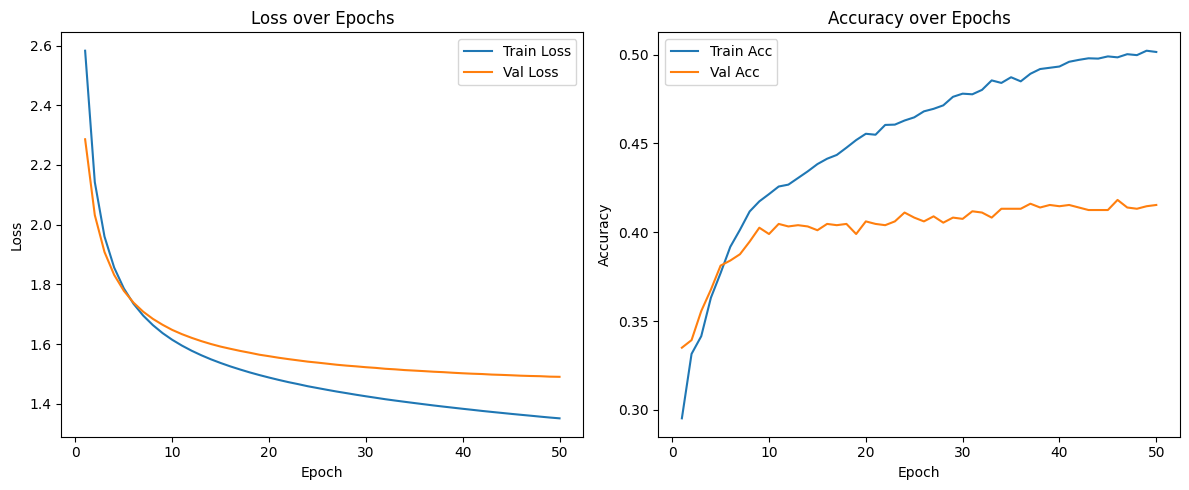

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTModel, ViTFeatureExtractor
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Настройки
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_size = 224
batch_size = 16
num_epochs = 50
num_classes = 20  # Диапазоны по 5 лет

# Feature extractor от ViT
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Кастомный датасет
class AgeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Сбор данных
def collect_data(root_dir):
    image_paths = []
    labels = []
    for age_str in os.listdir(root_dir):
        full_age_path = os.path.join(root_dir, age_str)
        if not os.path.isdir(full_age_path):
            continue
        try:
            age = int(age_str)
        except ValueError:
            continue
        label = min((age - 1) // 5, num_classes - 1)
        for fname in os.listdir(full_age_path):
            fpath = os.path.join(full_age_path, fname)
            if fpath.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(fpath)
                labels.append(label)
    return image_paths, labels

# Трансформации
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Пути
root_dir = 'out2'
image_paths, labels = collect_data(root_dir)
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

train_dataset = AgeDataset(train_paths, train_labels, transform)
val_dataset = AgeDataset(val_paths, val_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Модель
class AgeClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AgeClassifier, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.fc = nn.Linear(self.vit.config.hidden_size, num_classes)
    
    def forward(self, x):
        outputs = self.vit(pixel_values=x)
        cls_output = outputs.last_hidden_state[:, 0]
        return self.fc(cls_output)

model = AgeClassifier(num_classes).to(device)

# Замораживаем ViT
for param in model.vit.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

# История обучения
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Сохранение лучшей модели
best_val_acc = 0.0
best_model_path = 'best_vit_age_classifier.pth'

# Тренировка
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_bar = tqdm(train_loader, desc='Training', leave=False)

    for images, labels in train_bar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_bar.set_postfix(loss=loss.item())

    train_loss = total_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_total_loss = 0
    val_correct = 0
    val_total = 0
    val_bar = tqdm(val_loader, desc='Validation', leave=False)

    with torch.no_grad():
        for images, labels in val_bar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_bar.set_postfix(loss=loss.item())

    val_loss = val_total_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"  >>> Best model saved with val_acc = {best_val_acc:.4f}")

# Сохраняем финальную модель
torch.save(model.state_dict(), 'vit_age_classifier_final.pth')

# Графики
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Для задачи классификации максимальная метрика Accuracy составила 0.4182.


Epoch 1/30


  Train Loss: 1133.8808 | Train MAPE: 93.12%
  Val   Loss: 1035.9646 | Val   MAPE: 86.34%
  >>> Best model saved with val_loss = 1035.9646

Epoch 2/30


  Train Loss: 1040.8029 | Train MAPE: 84.57%
  Val   Loss: 949.8834 | Val   MAPE: 82.64%
  >>> Best model saved with val_loss = 949.8834

Epoch 3/30


  Train Loss: 955.4448 | Train MAPE: 82.42%
  Val   Loss: 870.8152 | Val   MAPE: 81.83%
  >>> Best model saved with val_loss = 870.8152

Epoch 4/30


  Train Loss: 877.2041 | Train MAPE: 82.15%
  Val   Loss: 798.4663 | Val   MAPE: 82.08%
  >>> Best model saved with val_loss = 798.4663

Epoch 5/30


  Train Loss: 805.4981 | Train MAPE: 82.32%
  Val   Loss: 732.2433 | Val   MAPE: 83.07%
  >>> Best model saved with val_loss = 732.2433

Epoch 6/30


  Train Loss: 739.5842 | Train MAPE: 83.13%
  Val   Loss: 671.5601 | Val   MAPE: 84.46%
  >>> Best model saved with val_loss = 671.5601

Epoch 7/30


  Train Loss: 679.2865 | Train MAPE: 84.25%
  Val   Loss: 616.2415 | Val   MAPE: 86.07%
  >>> Best model saved with val_loss = 616.2415

Epoch 8/30


  Train Loss: 624.1267 | Train MAPE: 85.76%
  Val   Loss: 565.4964 | Val   MAPE: 87.87%
  >>> Best model saved with val_loss = 565.4964

Epoch 9/30


  Train Loss: 573.7663 | Train MAPE: 86.93%
  Val   Loss: 519.5368 | Val   MAPE: 89.82%
  >>> Best model saved with val_loss = 519.5368

Epoch 10/30


  Train Loss: 527.9462 | Train MAPE: 88.56%
  Val   Loss: 477.8166 | Val   MAPE: 91.77%
  >>> Best model saved with val_loss = 477.8166

Epoch 11/30


  Train Loss: 486.3860 | Train MAPE: 89.98%
  Val   Loss: 440.1497 | Val   MAPE: 93.56%
  >>> Best model saved with val_loss = 440.1497

Epoch 12/30


  Train Loss: 448.7928 | Train MAPE: 91.30%
  Val   Loss: 406.1196 | Val   MAPE: 95.33%
  >>> Best model saved with val_loss = 406.1196

Epoch 13/30


  Train Loss: 415.0216 | Train MAPE: 92.78%
  Val   Loss: 375.8144 | Val   MAPE: 96.90%
  >>> Best model saved with val_loss = 375.8144

Epoch 14/30


  Train Loss: 384.6667 | Train MAPE: 93.72%
  Val   Loss: 348.5234 | Val   MAPE: 98.30%
  >>> Best model saved with val_loss = 348.5234

Epoch 15/30


  Train Loss: 357.6408 | Train MAPE: 94.93%
  Val   Loss: 324.5877 | Val   MAPE: 99.47%
  >>> Best model saved with val_loss = 324.5877

Epoch 16/30


  Train Loss: 333.6401 | Train MAPE: 95.86%
  Val   Loss: 303.1699 | Val   MAPE: 100.51%
  >>> Best model saved with val_loss = 303.1699

Epoch 17/30


  Train Loss: 312.3329 | Train MAPE: 96.63%
  Val   Loss: 284.2713 | Val   MAPE: 101.33%
  >>> Best model saved with val_loss = 284.2713

Epoch 18/30


  Train Loss: 293.5269 | Train MAPE: 97.26%
  Val   Loss: 267.7537 | Val   MAPE: 101.78%
  >>> Best model saved with val_loss = 267.7537

Epoch 19/30


  Train Loss: 276.9132 | Train MAPE: 97.88%
  Val   Loss: 253.0801 | Val   MAPE: 102.00%
  >>> Best model saved with val_loss = 253.0801

Epoch 20/30


  Train Loss: 262.3111 | Train MAPE: 97.65%
  Val   Loss: 240.1145 | Val   MAPE: 101.82%
  >>> Best model saved with val_loss = 240.1145

Epoch 21/30


  Train Loss: 249.4281 | Train MAPE: 97.26%
  Val   Loss: 228.7284 | Val   MAPE: 101.24%
  >>> Best model saved with val_loss = 228.7284

Epoch 22/30


  Train Loss: 238.0252 | Train MAPE: 96.66%
  Val   Loss: 218.6077 | Val   MAPE: 100.30%
  >>> Best model saved with val_loss = 218.6077

Epoch 23/30


  Train Loss: 227.8354 | Train MAPE: 95.56%
  Val   Loss: 209.5228 | Val   MAPE: 98.87%
  >>> Best model saved with val_loss = 209.5228

Epoch 24/30


  Train Loss: 218.7064 | Train MAPE: 93.83%
  Val   Loss: 201.2847 | Val   MAPE: 97.05%
  >>> Best model saved with val_loss = 201.2847

Epoch 25/30


  Train Loss: 210.4826 | Train MAPE: 92.13%
  Val   Loss: 193.8437 | Val   MAPE: 94.84%
  >>> Best model saved with val_loss = 193.8437

Epoch 26/30


  Train Loss: 202.9687 | Train MAPE: 90.15%
  Val   Loss: 186.9749 | Val   MAPE: 92.37%
  >>> Best model saved with val_loss = 186.9749

Epoch 27/30


  Train Loss: 196.0827 | Train MAPE: 87.38%
  Val   Loss: 180.6366 | Val   MAPE: 89.59%
  >>> Best model saved with val_loss = 180.6366

Epoch 28/30


  Train Loss: 189.6959 | Train MAPE: 85.07%
  Val   Loss: 174.7146 | Val   MAPE: 86.75%
  >>> Best model saved with val_loss = 174.7146

Epoch 29/30


  Train Loss: 183.7845 | Train MAPE: 82.51%
  Val   Loss: 169.2351 | Val   MAPE: 83.55%
  >>> Best model saved with val_loss = 169.2351

Epoch 30/30


  Train Loss: 178.2650 | Train MAPE: 79.37%
  Val   Loss: 164.0615 | Val   MAPE: 80.35%
  >>> Best model saved with val_loss = 164.0615


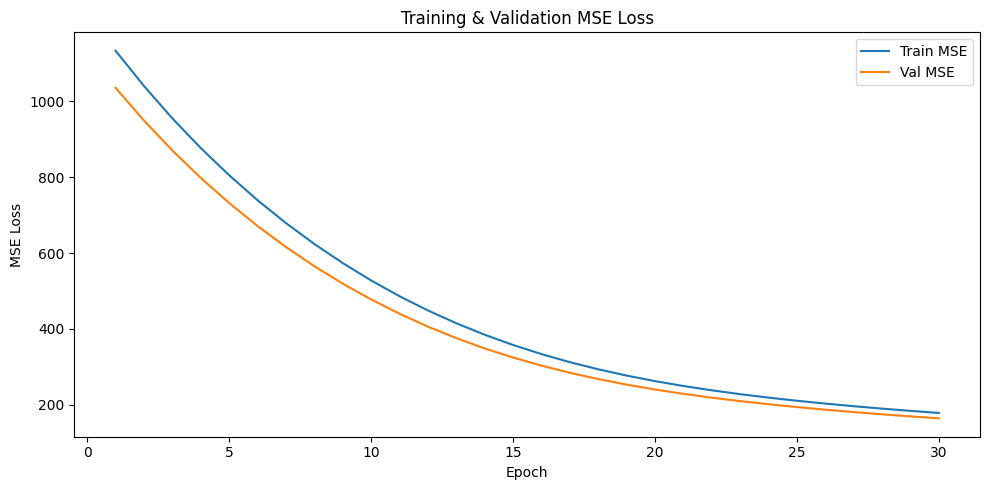

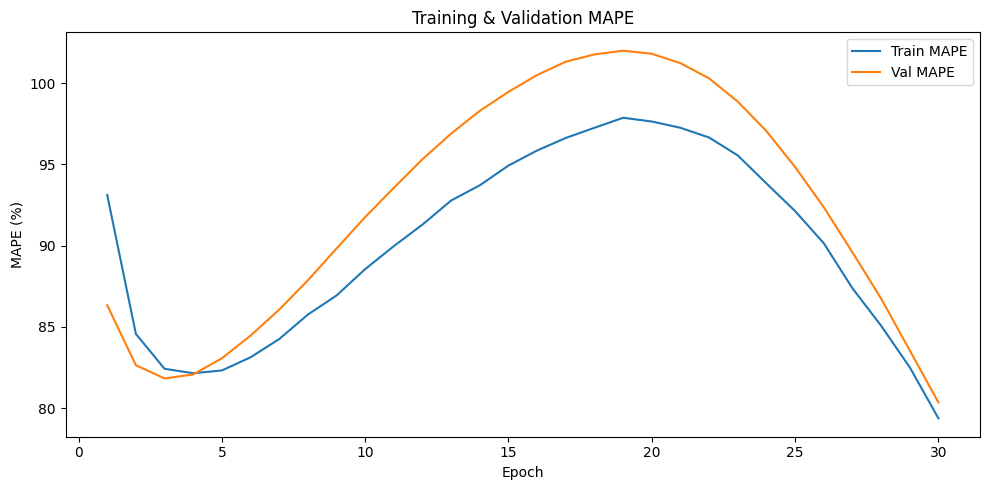

In [5]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTModel, ViTFeatureExtractor
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Настройки
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_size = 224
batch_size = 16
num_epochs = 30

# ViT Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# MAPE функция
def mean_absolute_percentage_error(y_pred, y_true):
    epsilon = 1e-8
    return torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Кастомный датасет
class AgeRegressionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = torch.tensor([self.labels[idx]], dtype=torch.float32)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Сбор данных
def collect_data(root_dir):
    image_paths = []
    labels = []
    for age_str in os.listdir(root_dir):
        full_age_path = os.path.join(root_dir, age_str)
        if not os.path.isdir(full_age_path):
            continue
        try:
            age = float(age_str)
        except ValueError:
            continue
        for fname in os.listdir(full_age_path):
            fpath = os.path.join(full_age_path, fname)
            if fpath.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(fpath)
                labels.append(age)
    return image_paths, labels

# Трансформации
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Пути
root_dir = 'out2'
image_paths, labels = collect_data(root_dir)
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

train_dataset = AgeRegressionDataset(train_paths, train_labels, transform)
val_dataset = AgeRegressionDataset(val_paths, val_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Модель
class AgeRegressor(nn.Module):
    def __init__(self):
        super(AgeRegressor, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.regressor = nn.Linear(self.vit.config.hidden_size, 1)

    def forward(self, x):
        outputs = self.vit(pixel_values=x)
        cls_output = outputs.last_hidden_state[:, 0]
        return self.regressor(cls_output)

model = AgeRegressor().to(device)

# Замораживаем ViT
for param in model.vit.parameters():
    param.requires_grad = False

criterion = nn.MSELoss()
optimizer = optim.Adam(model.regressor.parameters(), lr=1e-4)

train_losses = []
val_losses = []
train_mapes = []
val_mapes = []

best_val_loss = float('inf')
best_model_path = 'best_vit_age_regressor.pth'

# Тренировка
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_samples = 0
    mape_values = []

    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_bar = tqdm(train_loader, desc='Training', leave=False)

    for images, labels in train_bar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        total_samples += images.size(0)

        with torch.no_grad():
            batch_mape = mean_absolute_percentage_error(outputs, labels).item()
            mape_values.append(batch_mape)

        train_bar.set_postfix(loss=loss.item(), mape=batch_mape)

    train_loss = total_loss / total_samples
    train_mape = sum(mape_values) / len(mape_values)
    train_losses.append(train_loss)
    train_mapes.append(train_mape)

    model.eval()
    val_total_loss = 0
    val_total_samples = 0
    val_mape_values = []
    val_bar = tqdm(val_loader, desc='Validation', leave=False)

    with torch.no_grad():
        for images, labels in val_bar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_total_loss += loss.item() * images.size(0)
            val_total_samples += images.size(0)

            batch_mape = mean_absolute_percentage_error(outputs, labels).item()
            val_mape_values.append(batch_mape)

            val_bar.set_postfix(loss=loss.item(), mape=batch_mape)

    val_loss = val_total_loss / val_total_samples
    val_mape = sum(val_mape_values) / len(val_mape_values)
    val_losses.append(val_loss)
    val_mapes.append(val_mape)

    print(f"  Train Loss: {train_loss:.4f} | Train MAPE: {train_mape:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f} | Val   MAPE: {val_mape:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"  >>> Best model saved with val_loss = {best_val_loss:.4f}")

# Сохраняем финальную модель
torch.save(model.state_dict(), 'vit_age_regressor_final.pth')

# Графики
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train MSE')
plt.plot(epochs, val_losses, label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation MSE Loss')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_mapes, label='Train MAPE')
plt.plot(epochs, val_mapes, label='Val MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE (%)')
plt.title('Training & Validation MAPE')
plt.legend()
plt.tight_layout()
plt.show()


Для задачи регрессии использовал метрики MAE и MAPE. 
Лучший рещультат: MAE = 164, MAPE = 80.35%.

Здесь как loss использую MAPE. Обучение остановил вручную, так как loss перестал падать.

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTModel, ViTFeatureExtractor
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# === CONFIG ===
data_dir = "out2"  # структура: data/ages/1/, data/ages/2/, ..., data/ages/99/
batch_size = 16
num_epochs = 50
lr = 1e-4
image_size = 224
checkpoint_path = "best_vit_age_regressor.pth"
resume_training = False  # если True, продолжим с чекпойнта
start_epoch = 0

# === DEVICE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === TRANSFORMS ===
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# === CUSTOM DATASET ===
class AgeRegressionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for age_folder in sorted(os.listdir(root_dir)):
            folder_path = os.path.join(root_dir, age_folder)
            if not os.path.isdir(folder_path): continue
            age = float(age_folder)
            for fname in os.listdir(folder_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((os.path.join(folder_path, fname), age))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, age = self.samples[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(age, dtype=torch.float32)

# === DATA PREP ===
full_dataset = AgeRegressionDataset(data_dir, transform)
train_data, val_data = train_test_split(full_dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

# === MODEL ===
class AgeRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.regressor = nn.Sequential(
            nn.Linear(self.backbone.config.hidden_size, 1)
        )

    def forward(self, x):
        x = self.backbone(pixel_values=x).last_hidden_state[:, 0]
        return self.regressor(x).squeeze(1)

model = AgeRegressor().to(device)

# === OPTIMIZER & LOSS ===
optimizer = optim.Adam(model.parameters(), lr=lr)

def mean_absolute_percentage_error(y_pred, y_true):
    return torch.mean(torch.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

# === RESUME TRAINING ===
if resume_training and os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"✅ Модель загружена из {checkpoint_path}")
    start_epoch = 30  # или загрузи из файла, если хочешь torch.load('epoch.pth')

# === TRAIN LOOP ===
train_losses, val_losses = [], []
best_val_loss = float('inf')

for epoch in range(start_epoch, start_epoch + num_epochs):
    model.train()
    running_loss = 0
    pbar = tqdm(train_loader, desc=f"[Epoch {epoch+1}/{start_epoch + num_epochs}] Training")
    for images, ages in pbar:
        images, ages = images.to(device), ages.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = mean_absolute_percentage_error(outputs, ages)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        pbar.set_postfix(MAPE=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # === VALIDATION ===
    model.eval()
    val_loss = 0
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"[Epoch {epoch+1}/{start_epoch + num_epochs}] Validation")
        for images, ages in pbar:
            images, ages = images.to(device), ages.to(device)
            outputs = model(images)
            loss = mean_absolute_percentage_error(outputs, ages)
            val_loss += loss.item() * images.size(0)
            pbar.set_postfix(MAPE=loss.item())

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train MAPE={epoch_loss:.2f}%, Val MAPE={val_loss:.2f}%")

    # === SAVE BEST MODEL ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)
        torch.save(optimizer.state_dict(), 'optimizer.pth')
        torch.save(epoch + 1, 'epoch.pth')
        print(f"📦 Сохранили лучшую модель (Val MAPE: {val_loss:.2f}%)")

# === PLOT ===
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train MAPE")
plt.plot(val_losses, label="Val MAPE")
plt.xlabel("Epoch")
plt.ylabel("MAPE (%)")
plt.title("Age Regression with ViT")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


[Epoch 1/50] Validation: 100%|██████████| 88/88 [00:20<00:00,  4.24it/s, MAPE=77.7]


Epoch 1: Train MAPE=79.10%, Val MAPE=74.74%
📦 Сохранили лучшую модель (Val MAPE: 74.74%)


[Epoch 2/50] Validation: 100%|██████████| 88/88 [00:20<00:00,  4.20it/s, MAPE=63.1]


Epoch 2: Train MAPE=78.83%, Val MAPE=65.43%
📦 Сохранили лучшую модель (Val MAPE: 65.43%)


[Epoch 3/50] Validation: 100%|██████████| 88/88 [00:21<00:00,  4.17it/s, MAPE=48.6]


Epoch 3: Train MAPE=61.21%, Val MAPE=54.02%
📦 Сохранили лучшую модель (Val MAPE: 54.02%)


[Epoch 4/50] Validation: 100%|██████████| 88/88 [00:21<00:00,  4.15it/s, MAPE=37.3]


Epoch 4: Train MAPE=47.28%, Val MAPE=42.21%
📦 Сохранили лучшую модель (Val MAPE: 42.21%)


[Epoch 5/50] Validation: 100%|██████████| 88/88 [00:21<00:00,  4.14it/s, MAPE=32]  


Epoch 5: Train MAPE=34.91%, Val MAPE=31.02%
📦 Сохранили лучшую модель (Val MAPE: 31.02%)


[Epoch 6/50] Validation: 100%|██████████| 88/88 [00:21<00:00,  4.12it/s, MAPE=31.3]


Epoch 6: Train MAPE=44.58%, Val MAPE=38.29%


[Epoch 7/50] Validation: 100%|██████████| 88/88 [00:21<00:00,  4.12it/s, MAPE=28.6]


Epoch 7: Train MAPE=32.37%, Val MAPE=30.66%
📦 Сохранили лучшую модель (Val MAPE: 30.66%)


[Epoch 8/50] Validation: 100%|██████████| 88/88 [00:21<00:00,  4.11it/s, MAPE=29.1]


Epoch 8: Train MAPE=28.65%, Val MAPE=27.20%
📦 Сохранили лучшую модель (Val MAPE: 27.20%)


[Epoch 9/50] Validation: 100%|██████████| 88/88 [00:21<00:00,  4.12it/s, MAPE=32]  


Epoch 9: Train MAPE=27.82%, Val MAPE=26.97%
📦 Сохранили лучшую модель (Val MAPE: 26.97%)


[Epoch 10/50] Validation: 100%|██████████| 88/88 [00:21<00:00,  4.11it/s, MAPE=29.9]


Epoch 10: Train MAPE=25.35%, Val MAPE=26.12%
📦 Сохранили лучшую модель (Val MAPE: 26.12%)


[Epoch 11/50] Validation: 100%|██████████| 88/88 [00:21<00:00,  4.13it/s, MAPE=25.4]


Epoch 11: Train MAPE=23.01%, Val MAPE=23.80%
📦 Сохранили лучшую модель (Val MAPE: 23.80%)


[Epoch 12/50] Validation: 100%|██████████| 88/88 [00:21<00:00,  4.11it/s, MAPE=25.2]


Epoch 12: Train MAPE=21.21%, Val MAPE=24.40%


[Epoch 13/50] Validation: 100%|██████████| 88/88 [00:21<00:00,  4.11it/s, MAPE=22.9]


Epoch 13: Train MAPE=19.69%, Val MAPE=23.45%
📦 Сохранили лучшую модель (Val MAPE: 23.45%)


[Epoch 14/50] Validation: 100%|██████████| 88/88 [00:21<00:00,  4.07it/s, MAPE=26.5]


Epoch 14: Train MAPE=19.07%, Val MAPE=25.38%


[Epoch 15/50] Validation: 100%|██████████| 88/88 [00:21<00:00,  4.11it/s, MAPE=25.7]


Epoch 15: Train MAPE=17.99%, Val MAPE=25.20%


[Epoch 16/50] Training:   2%|▏         | 7/352 [00:05<04:26,  1.29it/s, MAPE=14.3]


KeyboardInterrupt: 

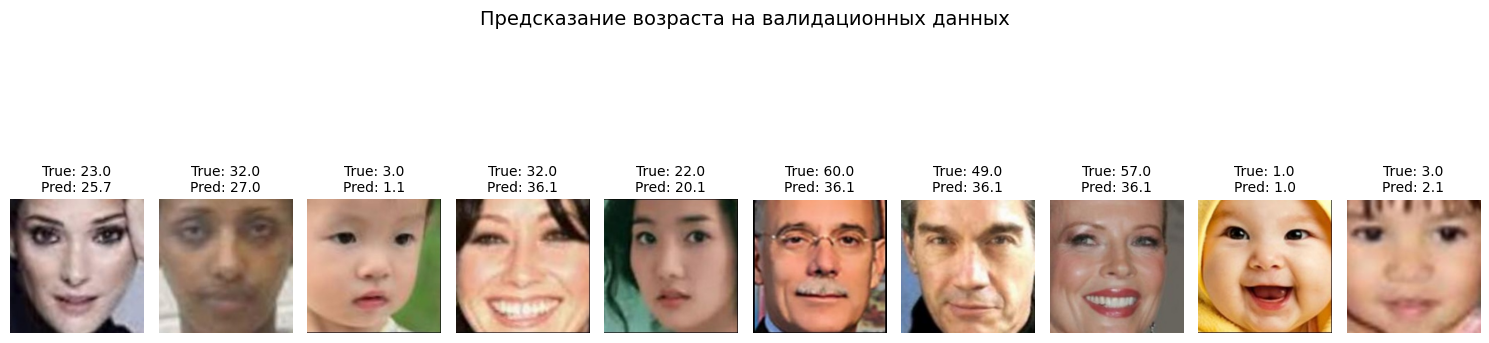

In [14]:
import random
import matplotlib.pyplot as plt

# === Загрузка модели ===
model = AgeRegressor().to(device)
model.load_state_dict(torch.load("best_vit_age_regressor.pth", map_location=device))
model.eval()

# === Выбор 5 случайных примеров из валидационного набора ===
samples = random.sample(range(len(val_data)), 10)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(samples):
    image, true_age = val_data[idx]
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        pred_age = model(input_tensor).item()

    # Отображение изображения
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 0.5 + 0.5).clip(0, 1)  # денормализация

    plt.subplot(1, 10, i + 1)
    plt.imshow(image_np)
    plt.title(f"True: {true_age:.1f}\nPred: {pred_age:.1f}", fontsize=10)
    plt.axis("off")

plt.suptitle("Предсказание возраста на валидационных данных", fontsize=14)
plt.tight_layout()
plt.show()


По результату работы, лучший результат показал способ с регрессией и использованием метрики MAPE. Однако, ошибочных предсказаний все равно много.